In [1]:
!python -V

Python 3.7.13


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [3]:
#@title import
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 46.4 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 50.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.5 MB 34.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 750 kB 33.3 MB/s 
     |████████████████████████████████| 407 kB 30.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=db99d4df878e62ae8f70ba20ef37705a141b68ba15959488698f3fedf9c8d01c
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir(r'/content/drive/My Drive/GNN_PPI')

In [6]:
#!pip install tensorboardX #==2.1
!pip install 'git+https://github.com/lanpa/tensorboardX'

  Cloning https://github.com/lanpa/tensorboardX to /tmp/pip-req-build-6mxrm32z
  Running command git clone -q https://github.com/lanpa/tensorboardX /tmp/pip-req-build-6mxrm32z
  Created wheel for tensorboardX: filename=tensorboardX-2.4.1-py2.py3-none-any.whl size=125259 sha256=6a71aa04dab085b15603e3c5f622a9805386b7d10f9c3e57e46e55efa893769b
  Stored in directory: /tmp/pip-ephem-wheel-cache-w6n19l05/wheels/b7/a3/60/1fb0fb70622c281e7b4450c3102965499af9875bbcf6cd277e
Successfully built tensorboardX


In [7]:
#@title 
#import os
import time
import math
import json
import random
import numpy as np
#import argparse
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import csv
import copy
from tensorboardX import SummaryWriter
from torch_geometric.nn import GINConv, JumpingKnowledge, global_mean_pool, SAGEConv   
from torch_geometric.data import Data, Dataset, InMemoryDataset, DataLoader

from torch.autograd import Variable
import gc
import torch.nn.functional as F

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [8]:
#@title utils
#For loading data
   
import os
import numpy as np
import random

def print_file(str_, save_file_path=None):
    print(str_)
    if save_file_path != None:
        f = open(save_file_path, 'a')
        print(str_, file=f)

class Metrictor_PPI:
    def __init__(self, pre_y, truth_y, is_binary=False):
        self.TP = 0
        self.FP = 0
        self.TN = 0
        self.FN = 0

        if is_binary:
            length = pre_y.shape[0]
            for i in range(length):
                if pre_y[i] == truth_y[i]:
                    if truth_y[i] == 1:
                        self.TP += 1
                    else:
                        self.TN += 1
                elif truth_y[i] == 1:
                    self.FN += 1
                elif pre_y[i] == 1:
                    self.FP += 1
            self.num = length

        else:
            N, C = pre_y.shape
            for i in range(N):
                for j in range(C):
                    if pre_y[i][j] == truth_y[i][j]:
                        if truth_y[i][j] == 1:
                            self.TP += 1
                        else:
                            self.TN += 1
                    elif truth_y[i][j] == 1:
                        self.FN += 1
                    elif truth_y[i][j] == 0:
                        self.FP += 1
            self.num = N * C
    
    def show_result(self, is_print=False, file=None):
        self.Accuracy = (self.TP + self.TN) / (self.num + 1e-10)
        self.Precision = self.TP / (self.TP + self.FP + 1e-10)
        self.Recall = self.TP / (self.TP + self.FN + 1e-10)
        self.F1 = 2 * self.Precision * self.Recall / (self.Precision + self.Recall + 1e-10)
        if is_print:
            print_file("Accuracy: {}".format(self.Accuracy), file)
            print_file("Precision: {}".format(self.Precision), file)
            print_file("Recall: {}".format(self.Recall), file)
            print_file("F1-Score: {}".format(self.F1), file)

class UnionFindSet(object):
    def __init__(self, m):
        # m, n = len(grid), len(grid[0])
        self.roots = [i for i in range(m)]
        self.rank = [0 for i in range(m)]
        self.count = m
        
        for i in range(m):
            self.roots[i] = i
 
    def find(self, member):
        tmp = []
        while member != self.roots[member]:
            tmp.append(member)
            member = self.roots[member]
        for root in tmp:
            self.roots[root] = member
        return member
        
    def union(self, p, q):
        parentP = self.find(p)
        parentQ = self.find(q)
        if parentP != parentQ:
            if self.rank[parentP] > self.rank[parentQ]:
                self.roots[parentQ] = parentP
            elif self.rank[parentP] < self.rank[parentQ]:
                self.roots[parentP] = parentQ
            else:
                self.roots[parentQ] = parentP
                self.rank[parentP] -= 1
            self.count -= 1


def get_bfs_sub_graph(ppi_list, node_num, node_to_edge_index, sub_graph_size):

    candiate_node = []
    selected_edge_index = []
    selected_node = []

    random_node = random.randint(0, node_num - 1)
    while len(node_to_edge_index[random_node]) > 5:
        random_node = random.randint(0, node_num - 1)
    candiate_node.append(random_node)

    while len(selected_edge_index) < sub_graph_size:
        cur_node = candiate_node.pop(0)
        selected_node.append(cur_node)
        for edge_index in node_to_edge_index[cur_node]:

            if edge_index not in selected_edge_index:
                selected_edge_index.append(edge_index)

                end_node = -1
                if ppi_list[edge_index][0] == cur_node:
                    end_node = ppi_list[edge_index][1]
                else:
                    end_node = ppi_list[edge_index][0]

                if end_node not in selected_node and end_node not in candiate_node:
                    candiate_node.append(end_node)
            else:
                continue
        # print(len(selected_edge_index), len(candiate_node))
    node_list = candiate_node + selected_node
    # print(len(node_list), len(selected_edge_index))
    return selected_edge_index

def get_dfs_sub_graph(ppi_list, node_num, node_to_edge_index, sub_graph_size):
    
    stack = []
    selected_edge_index = []
    selected_node = []

    random_node = random.randint(0, node_num - 1)
    while len(node_to_edge_index[random_node]) > 5:
        random_node = random.randint(0, node_num - 1)
    stack.append(random_node)

    while len(selected_edge_index) < sub_graph_size:
        # print(len(selected_edge_index), len(stack), len(selected_node))
        cur_node = stack[-1]
        if cur_node in selected_node:
            flag = True
            for edge_index in node_to_edge_index[cur_node]:
                if flag:
                    end_node = -1
                    if ppi_list[edge_index][0] == cur_node:
                        end_node = ppi_list[edge_index][1]
                    else:
                        end_node = ppi_list[edge_index][0]
                    
                    if end_node in selected_node:
                        continue
                    else:
                        stack.append(end_node)
                        flag = False
                else:
                    break
            if flag:
                stack.pop()
            continue
        else:
            selected_node.append(cur_node)
            for edge_index in node_to_edge_index[cur_node]:
                if edge_index not in selected_edge_index:
                    selected_edge_index.append(edge_index)
    
    return selected_edge_index

class GNN_DATA:
    def __init__(self, ppi_path, exclude_protein_path=None, max_len=2000, skip_head=True, p1_index=0, p2_index=1, label_index=2, graph_undirection=True, bigger_ppi_path=None):
        self.ppi_list = []
        self.ppi_dict = {}
        self.ppi_label_list = []
        self.protein_dict = {}
        self.protein_name = {}
        self.ppi_path = ppi_path
        self.bigger_ppi_path = bigger_ppi_path
        self.max_len = max_len

        name = 0
        ppi_name = 0
        # maxlen = 0
        self.node_num = 0
        self.edge_num = 0
        if exclude_protein_path != None:
            with open(exclude_protein_path, 'r') as f:
                ex_protein = json.load(f)
                f.close()
            ex_protein = {p:i for i, p in enumerate(ex_protein)}
        else:
            ex_protein = {}

        class_map = {'reaction':0, 'binding':1, 'ptmod':2, 'activation':3, 'inhibition':4, 'catalysis':5, 'expression':6}

        for line in tqdm(open(ppi_path)):
            if skip_head:
                skip_head = False
                continue
            line = line.strip().split('\t')

            if line[p1_index] in ex_protein.keys() or line[p2_index] in ex_protein.keys():
                continue

            # get node and node name
            if line[p1_index] not in self.protein_name.keys():
                self.protein_name[line[p1_index]] = name
                name += 1
            
            if line[p2_index] not in self.protein_name.keys():
                self.protein_name[line[p2_index]] = name
                name += 1

            # get edge and its label
            temp_data = ""
            if line[p1_index] < line[p2_index]:
                temp_data = line[p1_index] + "__" + line[p2_index]
            else:
                temp_data = line[p2_index] + "__" + line[p1_index]

            if temp_data not in self.ppi_dict.keys():
                self.ppi_dict[temp_data] = ppi_name
                temp_label = [0, 0, 0, 0, 0, 0, 0]
                temp_label[class_map[line[label_index]]] = 1
                self.ppi_label_list.append(temp_label)
                ppi_name += 1
            else:
                index = self.ppi_dict[temp_data]
                temp_label = self.ppi_label_list[index]
                temp_label[class_map[line[label_index]]] = 1
                self.ppi_label_list[index] = temp_label
        
        if bigger_ppi_path != None:
            skip_head = True
            for line in tqdm(open(bigger_ppi_path)):
                if skip_head:
                    skip_head = False
                    continue
                line = line.strip().split('\t')

                if line[p1_index] not in self.protein_name.keys():
                    self.protein_name[line[p1_index]] = name
                    name += 1
                
                if line[p2_index] not in self.protein_name.keys():
                    self.protein_name[line[p2_index]] = name
                    name += 1
                
                temp_data = ""
                if line[p1_index] < line[p2_index]:
                    temp_data = line[p1_index] + "__" + line[p2_index]
                else:
                    temp_data = line[p2_index] + "__" + line[p1_index]
                
                if temp_data not in self.ppi_dict.keys():
                    self.ppi_dict[temp_data] = ppi_name
                    temp_label = [0, 0, 0, 0, 0, 0, 0]
                    temp_label[class_map[line[label_index]]] = 1
                    self.ppi_label_list.append(temp_label)
                    ppi_name += 1
                else:
                    index = self.ppi_dict[temp_data]
                    temp_label = self.ppi_label_list[index]
                    temp_label[class_map[line[label_index]]] = 1
                    self.ppi_label_list[index] = temp_label

        i = 0
        for ppi in tqdm(self.ppi_dict.keys()):
            name = self.ppi_dict[ppi]
            assert name == i
            i += 1
            temp = ppi.strip().split('__')
            self.ppi_list.append(temp)


        ppi_num = len(self.ppi_list)
        self.origin_ppi_list = copy.deepcopy(self.ppi_list)
        assert len(self.ppi_list) == len(self.ppi_label_list)
        for i in tqdm(range(ppi_num)):
            seq1_name = self.ppi_list[i][0]
            seq2_name = self.ppi_list[i][1]
            # print(len(self.protein_name))
            self.ppi_list[i][0] = self.protein_name[seq1_name]
            self.ppi_list[i][1] = self.protein_name[seq2_name]
        
        if graph_undirection:
            for i in tqdm(range(ppi_num)):
                temp_ppi = self.ppi_list[i][::-1]
                temp_ppi_label = self.ppi_label_list[i]
                # if temp_ppi not in self.ppi_list:
                self.ppi_list.append(temp_ppi)
                self.ppi_label_list.append(temp_ppi_label)

        self.node_num = len(self.protein_name)
        self.edge_num = len(self.ppi_list)
    
    def get_protein_aac(self, pseq_path):
        # aac: amino acid sequences

        self.pseq_path = pseq_path
        self.pseq_dict = {}
        self.protein_len = []

        for line in tqdm(open(self.pseq_path)):
            line = line.strip().split('\t')
            if line[0] not in self.pseq_dict.keys():
                self.pseq_dict[line[0]] = line[1]
                self.protein_len.append(len(line[1]))
        
        print("protein num: {}".format(len(self.pseq_dict)))
        print("protein average length: {}".format(np.average(self.protein_len)))
        print("protein max & min length: {}, {}".format(np.max(self.protein_len), np.min(self.protein_len)))

    def embed_normal(self, seq, dim):
        if len(seq) > self.max_len:
            return seq[:self.max_len]
        elif len(seq) < self.max_len:
            less_len = self.max_len - len(seq)
            return np.concatenate((seq, np.zeros((less_len, dim))))
        return seq
        

    def vectorize(self, vec_path):
        self.acid2vec = {}
        self.dim = None
        for line in open(vec_path):
            line = line.strip().split('\t')
            temp = np.array([float(x) for x in line[1].split()])
            self.acid2vec[line[0]] = temp
            if self.dim is None:
                self.dim = len(temp)
        print("acid vector dimension: {}".format(self.dim))

        self.pvec_dict = {}

        for p_name in tqdm(self.pseq_dict.keys()):
            temp_seq = self.pseq_dict[p_name]
            temp_vec = []
            for acid in temp_seq:
                temp_vec.append(self.acid2vec[acid])
            temp_vec = np.array(temp_vec)

            temp_vec = self.embed_normal(temp_vec, self.dim)

            self.pvec_dict[p_name] = temp_vec

    def get_feature_origin(self, pseq_path, vec_path):
        self.get_protein_aac(pseq_path)

        self.vectorize(vec_path)

        self.protein_dict = {}
        for name in tqdm(self.protein_name.keys()):
            self.protein_dict[name] = self.pvec_dict[name]

    def get_connected_num(self):
        self.ufs = UnionFindSet(self.node_num)
        ppi_ndary = np.array(self.ppi_list)
        for edge in ppi_ndary:
            start, end = edge[0], edge[1]
            self.ufs.union(start, end)

    def generate_data(self):
        self.get_connected_num()

        print("Connected domain num: {}".format(self.ufs.count))

        ppi_list = np.array(self.ppi_list)
        ppi_label_list = np.array(self.ppi_label_list)

        self.edge_index = torch.tensor(ppi_list, dtype=torch.long)
        self.edge_attr = torch.tensor(ppi_label_list, dtype=torch.long)
        self.x = []
        i = 0
        for name in self.protein_name:
            assert self.protein_name[name] == i
            i += 1
            self.x.append(self.protein_dict[name])
        
        self.x = np.array(self.x)
        self.x = torch.tensor(self.x, dtype=torch.float)

        self.data = Data(x=self.x, edge_index=self.edge_index.T, edge_attr_1=self.edge_attr)
    
    def split_dataset(self, train_valid_index_path, test_size=0.2, random_new=False, mode='random'):
        if random_new:
            if mode == 'random':
                ppi_num = int(self.edge_num // 2)
                random_list = [i for i in range(ppi_num)]
                random.shuffle(random_list)

                self.ppi_split_dict = {}
                self.ppi_split_dict['train_index'] = random_list[: int(ppi_num * (1-test_size))]
                self.ppi_split_dict['valid_index'] = random_list[int(ppi_num * (1-test_size)) :]

                jsobj = json.dumps(self.ppi_split_dict)
                with open(train_valid_index_path, 'w') as f:
                    f.write(jsobj)
                    f.close()

            elif mode == 'bfs' or mode == 'dfs':
                print("use {} methed split train and valid dataset".format(mode))
                node_to_edge_index = {}
                edge_num = int(self.edge_num // 2)
                for i in range(edge_num):
                    edge = self.ppi_list[i]
                    if edge[0] not in node_to_edge_index.keys():
                        node_to_edge_index[edge[0]] = []
                    node_to_edge_index[edge[0]].append(i)

                    if edge[1] not in node_to_edge_index.keys():
                        node_to_edge_index[edge[1]] = []
                    node_to_edge_index[edge[1]].append(i)
                
                node_num = len(node_to_edge_index)

                sub_graph_size = int(edge_num * test_size)
                if mode == 'bfs':
                    selected_edge_index = get_bfs_sub_graph(self.ppi_list, node_num, node_to_edge_index, sub_graph_size)
                elif mode == 'dfs':
                    selected_edge_index = get_dfs_sub_graph(self.ppi_list, node_num, node_to_edge_index, sub_graph_size)
                
                all_edge_index = [i for i in range(edge_num)]

                unselected_edge_index = list(set(all_edge_index).difference(set(selected_edge_index)))

                self.ppi_split_dict = {}
                self.ppi_split_dict['train_index'] = unselected_edge_index
                self.ppi_split_dict['valid_index'] = selected_edge_index

                assert len(unselected_edge_index) + len(selected_edge_index) == edge_num

                jsobj = json.dumps(self.ppi_split_dict)
                with open(train_valid_index_path, 'w') as f:
                    f.write(jsobj)
                    f.close()
            
            else:
                print("your mode is {}, you should use bfs, dfs or random".format(mode))
                return
        else:
            with open(train_valid_index_path, 'r') as f:
                self.ppi_split_dict = json.load(f)
                f.close()

## Model

In [9]:
#@title base architecutures
# mode: 'self' or 'ngb'
# For graph embeding and hidden layer of neural net, follow the architecture in https://arxiv.org/pdf/2105.06709.pdf

class GIN_Net_self(torch.nn.Module):
    def __init__(self, in_len=2000, in_feature=13, gin_in_feature=256, num_layers=1,
                sigma=0.1,is_relative_detach = True, hidden=512, use_jk=False, pool_size=3, cnn_hidden=1, train_eps=True, 
                feature_fusion=None, class_num=7):
        super(GIN_Net_self, self).__init__()
        self.use_jk = use_jk
        self.train_eps = train_eps
        self.feature_fusion = feature_fusion
        self.sigma=sigma
        self.is_relative_detach = is_relative_detach       
        self.conv1d = nn.Conv1d(in_channels=in_feature, out_channels=cnn_hidden, kernel_size=3, padding=0)
        self.bn1 = nn.BatchNorm1d(cnn_hidden)
        self.biGRU = nn.GRU(cnn_hidden, cnn_hidden, bidirectional=True, batch_first=True, num_layers=1)
        self.maxpool1d = nn.MaxPool1d(pool_size, stride=pool_size)
        self.global_avgpool1d = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(math.floor(in_len / pool_size), gin_in_feature)  

    def reset_parameters(self):        
        self.conv1d.reset_parameters()
        self.fc1.reset_parameters()    

    def forward(self, x, edge_index, train_edge_id, p=0.5):
        x = x.transpose(1, 2)
        x = self.conv1d(x)
        x = self.bn1(x)
        x = self.maxpool1d(x)
        x = x.transpose(1, 2)
        x, _ = self.biGRU(x)
        x = self.global_avgpool1d(x)
        x = x.squeeze()
        x = self.fc1(x)
        return x

class GIN_Net_ngb(torch.nn.Module):
    def __init__(self, in_len=2000, in_feature=13, gin_in_feature=256, num_layers=1
                ,sigma=0.1,is_relative_detach = True, hidden=512, use_jk=False, pool_size=3, cnn_hidden=1, train_eps=True, 
                feature_fusion=None, class_num=7):
        super(GIN_Net_ngb, self).__init__()
        self.use_jk = use_jk
        self.train_eps = train_eps
        self.feature_fusion = feature_fusion

        self.sigma=sigma
        self.is_relative_detach = is_relative_detach
        self.gin_conv1 = GINConv( 
            nn.Sequential(
                nn.Linear(gin_in_feature, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.BatchNorm1d(hidden),
            ), train_eps=self.train_eps
        )
        self.gin_convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.gin_convs.append(
                GINConv(
                    nn.Sequential(
                        nn.Linear(hidden, hidden),
                        nn.ReLU(),
                        nn.Linear(hidden, hidden),
                        nn.ReLU(),
                        nn.BatchNorm1d(hidden),
                    ), train_eps=self.train_eps
                )
            )
        if self.use_jk:
            mode = 'cat'
            self.jump = JumpingKnowledge(mode)
            self.lin1 = nn.Linear(num_layers*hidden, hidden)
        else:
            self.lin1 = nn.Linear(hidden, hidden)
        self.lin2 = nn.Linear(hidden, hidden)
        self.fc2 = nn.Linear(hidden, class_num)
    
    def reset_parameters(self):
        self.gin_conv1.reset_parameters()
        for gin_conv in self.gin_convs:
            gin_conv.reset_parameters()
        
        if self.use_jk:
            self.jump.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        self.fc2.reset_parameters()
    
    def forward(self, x, edge_index, train_edge_id, p=0.5):
        x = self.gin_conv1(x, edge_index)
        xs = [x]
        for conv in self.gin_convs:
            x = conv(x, edge_index)
            xs += [x]

        if self.use_jk:
            x = self.jump(xs)
        
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=p, training=self.training)
        x = self.lin2(x)
        node_id = edge_index[:, train_edge_id]
        x1 = x[node_id[0]]
        x2 = x[node_id[1]]

        if self.feature_fusion == 'concat':
            x = torch.cat([x1, x2], dim=1)
        else:
            x = torch.mul(x1, x2)
        x = self.fc2(x)

        return x        

In [10]:
#@title Loss functions

#student loss (without KD)
def loss_fn_s(logits_self, logits_ngb, labels):
  alpha=0.3 
  beta=0.3


  kl_loss_fn = nn.KLDivLoss(reduction="batchmean")#.to(device)
  loss_fn_ce = nn.BCEWithLogitsLoss().to(device)

  loss_fn_ce_1=loss_fn_ce(logits_self,labels)
  loss_fn_ce_2=loss_fn_ce(logits_ngb,labels)
  m=nn.LogSoftmax()

  d_self=m(logits_self).detach()
  d_ngb=m(logits_ngb).detach()


  kl_loss = kl_loss_fn(d_self , d_ngb).detach()


  return alpha*loss_fn_ce_1+beta*loss_fn_ce_2+(1.0-(alpha+beta))*kl_loss


#student loss with KD
def loss_fn_kd_s(logits_self, logits_ngb,  logits_t, labels):
  alpha=0.3
  beta=0.3
  T=4.0
  
  kl_loss_fn = nn.KLDivLoss().to(device)
  loss_fn_ce = nn.BCEWithLogitsLoss().to(device)

  loss_fn_ce_1=loss_fn_ce(logits_self,labels)
  loss_fn_ce_2=loss_fn_ce(logits_ngb,labels)

  m = nn.Sigmoid()

  d_self=m(logits_self/T)
  d_ngb=m(logits_ngb/T)
  d_t=m(logits_t/T)


  kl_loss_t1=kl_loss_fn(d_self,d_t)*T*T
  kl_loss_t2=kl_loss_fn(d_ngb,d_t)*T*T



  return (0.5)*loss_fn_s(logits_self, logits_ngb, labels)+(0.5)*(kl_loss_t1+kl_loss_t2)


In [11]:
#@title Train

def train_s(model_self, model_ngb, graph, ppi_list, loss_fn, optimizer_self, optimizer_ngb, device,
        result_file_pathr, summary_writerr , save_path
        ,scheduler1,scheduler2, batch_size=256, epochs=1
        ): #epochs=1000 ,batch_size=512
    for epoch in range(589,epochs):
        steps = math.ceil(len(graph.train_mask) / batch_size)
        model_self.train() 
        model_ngb.train()               
        random.shuffle(graph.train_mask)
        for step in range(steps):
            if step == steps-1:
              train_edge_id = graph.train_mask[step*batch_size:]
            else:
              train_edge_id = graph.train_mask[step*batch_size : step*batch_size + batch_size]
            label = graph.edge_attr_1[train_edge_id]            
            exact_input=graph.x
            noise_1 = torch.randn_like(exact_input)
            noisy_input = ((noise_1 + exact_input).detach() - exact_input).detach() + exact_input
            ngb_output_self=model_ngb(model_self(noisy_input,graph.edge_index, train_edge_id),graph.edge_index, train_edge_id)

            exact_self=model_self(graph.x,graph.edge_index, train_edge_id)
            noise=torch.randn_like(exact_self)
            noisy_input_ngb=((noise + exact_self).detach() - exact_self).detach() + exact_self
            ngb_output_ngb=model_ngb(noisy_input_ngb,graph.edge_index, train_edge_id)

            model_self.train()
            model_ngb.train()

            label = label.type(torch.FloatTensor).to(device)
            self_loss=loss_fn_s(ngb_output_self, ngb_output_ngb, label)
            ngb_loss=loss_fn_s(ngb_output_self, ngb_output_ngb, label)
            
            del exact_input,noise_1,exact_self,noise,noisy_input_ngb
            gc.collect()
            optimizer_self.zero_grad()
            optimizer_ngb.zero_grad()

            self_loss.backward(retain_graph=True)            
            ngb_loss.backward(retain_graph=True) 

            optimizer_self.step()
            optimizer_ngb.step()

            m = nn.Sigmoid()
            pre_result = ((m(ngb_output_ngb) > 0.5) == (m(ngb_output_self)> 0.5)).type(torch.FloatTensor).to(device)
            metrics = Metrictor_PPI(pre_result.cpu().data, label.cpu().data)
            metrics.show_result()
            print_file("epoch: {}, step: {}, Train: label_loss: {}, precision: {}, recall: {}, f1: {}"
                        .format(epoch, step, ngb_loss, metrics.Precision, metrics.Recall, metrics.F1))
            v=random.randint(0,100)
            torch.save(model_self.state_dict(), '/content/drive/My Drive/GNN_PPI/'+str(v)+'self_train.ckpt')
            torch.save(model_ngb.state_dict(), '/content/drive/My Drive/GNN_PPI/'+str(v)+'ngb_train.ckpt')  
            
            torch.cuda.empty_cache()
            del metrics,pre_result,ngb_output_self,ngb_output_ngb
            gc.collect()
        torch.save({'epoch': epoch,
                    'state_dict': model_self.state_dict()},
                    os.path.join(save_path, 'gnn_model_self_train.ckpt'))
        torch.save({'epoch': epoch,
                    'state_dict': model_ngb.state_dict()},
                    os.path.join(save_path, 'gnn_model_nbg_train.ckpt'))

In [ ]:
model_self.eval()

GIN_Net_self(
  (conv1d): Conv1d(13, 1, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (biGRU): GRU(1, 1, batch_first=True, bidirectional=True)
  (maxpool1d): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (global_avgpool1d): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=666, out_features=256, bias=True)
)

In [ ]:
model_ngb.eval()

GIN_Net_ngb(
  (gin_conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  ))
  (gin_convs): ModuleList()
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

In [ ]:
#@title 
#large dataset memory crash
#initialization and train

# ppi_path = "/content/drive/My Drive/GNN_PPI/data/9606.protein.actions.all_connected.txt"
# ppi_data = GNN_DATA(ppi_path)

# pseq_path = "/content/drive/My Drive/GNN_PPI/data/protein.STRING_all_connected.sequences.dictionary.tsv"
# vec_path = "/content/drive/My Drive/GNN_PPI/data/vec5_CTC.txt"

# ppi_data.get_feature_origin(pseq_path=pseq_path, vec_path=vec_path)
# ppi_data.generate_data()

# split_new=True
# split_mode = "bfs"
# train_valid_index_path = "/content/drive/My Drive/GNN_PPI/string.bfs.fold1_truncated.json"
# ppi_data.split_dataset(train_valid_index_path, random_new=split_new, mode=split_mode)

# split_new=False

# graph = ppi_data.data

# ppi_list = ppi_data.ppi_list

# graph.train_mask = ppi_data.ppi_split_dict['train_index']
# graph.val_mask = ppi_data.ppi_split_dict['valid_index']


# # graph.edge_index_got = torch.cat((graph.edge_index[:, graph.train_mask], graph.edge_index[:, graph.train_mask][[1, 0]]), dim=1)
# # graph.edge_attr_got = torch.cat((graph.edge_attr_1[graph.train_mask], graph.edge_attr_1[graph.train_mask]), dim=0)
# # graph.train_mask_got = [i for i in range(len(graph.train_mask))]

4775155it [00:14, 321855.80it/s]
100%|██████████| 593397/593397 [00:00<00:00, 620351.03it/s]
15335it [00:00, 296137.81it/s]


protein num: 15335
protein average length: 603.6829475057059
protein max & min length: 33423, 25
acid vector dimension: 13


100%|██████████| 15335/15335 [00:00<00:00, 1553539.73it/s]


Connected domain num: 1
use bfs methed split train and valid dataset


In [12]:
#@title Initialization and train

ppi_path = "/content/drive/My Drive/GNN_PPI/data/protein.actions.SHS27k.STRING.txt"
ppi_data = GNN_DATA(ppi_path)

pseq_path = "/content/drive/My Drive/GNN_PPI/data/protein.SHS27k.sequences.dictionary.tsv"
vec_path = "/content/drive/My Drive/GNN_PPI/data/vec5_CTC.txt"

ppi_data.get_feature_origin(pseq_path=pseq_path, vec_path=vec_path)
ppi_data.generate_data()

split_new=True
split_mode = "bfs"
train_valid_index_path = "/content/drive/My Drive/GNN_PPI/string.bfs.fold1_truncated.json"
ppi_data.split_dataset(train_valid_index_path, random_new=split_new, mode=split_mode)

split_new=False

graph = ppi_data.data

ppi_list = ppi_data.ppi_list

graph.train_mask = ppi_data.ppi_split_dict['train_index']
graph.val_mask = ppi_data.ppi_split_dict['valid_index']

63409it [00:00, 132809.24it/s]
100%|██████████| 7624/7624 [00:00<00:00, 1102477.98it/s]
1690it [00:00, 7244.07it/s]


protein num: 1690
protein average length: 571.0644970414202
protein max & min length: 5171, 51
acid vector dimension: 13


100%|██████████| 1690/1690 [00:00<00:00, 1757593.30it/s]


Connected domain num: 18
use bfs methed split train and valid dataset


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
graph.to(device)

Data(x=[1690, 2000, 13], edge_index=[2, 15248], edge_attr_1=[15248, 7], train_mask=[6069], val_mask=[1555])

In [14]:
#@title
model_self = GIN_Net_self(in_len=2000, in_feature=13, gin_in_feature=256, num_layers=1,
                sigma=0.1,is_relative_detach = True, pool_size=3, cnn_hidden=1).to(device)

model_ngb = GIN_Net_ngb(in_len=2000, in_feature=13, gin_in_feature=256, num_layers=1, 
                sigma=0.1,is_relative_detach = True, pool_size=3, cnn_hidden=1).to(device) 

optimizer_self = torch.optim.Adam(model_self.parameters(), lr=0.001, weight_decay=5e-4)
optimizer_ngb = torch.optim.Adam(model_ngb.parameters(), lr=0.001, weight_decay=5e-4)


In [15]:
#@title
use_lr_scheduler = "True"
scheduler_1 = None
scheduler_2 = None
if use_lr_scheduler:
    scheduler_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_self, mode='min', factor=0.5, patience=20, verbose=True)
    scheduler_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_self, mode='min', factor=0.5, patience=20, verbose=True)

description = "test_string_bfs"
save_path = "/content/drive/My Drive/GNN_PPI/save_model/"
time_stamp = time.strftime("%Y-%m-%d %H:%M:%S")
save_path = os.path.join(save_path, "gnn_{}_{}".format(description, time_stamp))
result_file_path = os.path.join(save_path, "valid_results.txt")
os.mkdir(save_path)
summary_writer = SummaryWriter(save_path)
graph_only_train = "False"
summary_writer = SummaryWriter(save_path)

In [ ]:
train_s(model_self, model_ngb, graph, ppi_list, loss_fn_s, optimizer_self, optimizer_ngb, device
    ,result_file_path, summary_writer, save_path, scheduler_1, scheduler_2,batch_size=256, epochs=1)
summary_writer.close()

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 0, step: 0, Train: label_loss: 0.41707131266593933, precision: 0.35396518375238356, recall: 0.5700934579438364, f1: 0.43675417656366156
1
epoch: 0, step: 1, Train: label_loss: 0.4033361077308655, precision: 0.3323029366305771, recall: 0.7190635451503814, f1: 0.45454545450217265
2
epoch: 0, step: 2, Train: label_loss: 0.3951815366744995, precision: 0.3066572237960123, recall: 0.7289562289561062, f1: 0.43170488530223916
3
epoch: 0, step: 3, Train: label_loss: 0.38447266817092896, precision: 0.2939093484419055, recall: 0.689368770764005, f1: 0.4121151936025353
4
epoch: 0, step: 4, Train: label_loss: 0.3779138922691345, precision: 0.2893470790377808, recall: 0.7159863945577013, f1: 0.4121390112169183
5
epoch: 0, step: 5, Train: label_loss: 0.37835419178009033, precision: 0.30486111111108993, recall: 0.745331069609381, f1: 0.4327254804910348
6
epoch: 0, step: 6, Train: label_loss: 0.36933231353759766, precision: 0.30769230769228634, recall: 0.744966442952895, f1: 0.4355076017241564
7

In [ ]:
train_s(model_self, model_ngb, graph, ppi_list, loss_fn_s, optimizer_self, optimizer_ngb, device
    ,result_file_path, summary_writer, save_path, scheduler_1, scheduler_2,batch_size=256, epochs=10)
summary_writer.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 0, step: 0, Train: label_loss: 0.35008370876312256, precision: 0.31675392670154995, recall: 0.7857142857141581, f1: 0.4514925372724378
epoch: 0, step: 1, Train: label_loss: 0.3366279602050781, precision: 0.3068987749838616, recall: 0.7933333333332011, f1: 0.44258484421821676
epoch: 0, step: 2, Train: label_loss: 0.33981582522392273, precision: 0.32178547634907917, recall: 0.7957166392090945, f1: 0.45825426940866487
epoch: 0, step: 3, Train: label_loss: 0.330141544342041, precision: 0.3040317250495503, recall: 0.754098360655614, f1: 0.4333490343443087
epoch: 0, step: 4, Train: label_loss: 0.33630648255348206, precision: 0.3091032608695442, recall: 0.733870967741817, f1: 0.43499043972880613
epoch: 0, step: 5, Train: label_loss: 0.33744385838508606, precision: 0.2899045020463649, recall: 0.7154882154880949, f1: 0.41262135918222004
epoch: 0, step: 6, Train: label_loss: 0.3324030339717865, precision: 0.3011250827266511, recall: 0.7434640522874602, f1: 0.42863871875308457
epoch: 0, st

In [16]:
with torch.no_grad():
  model_self.eval()
  model_ngb.eval()

In [ ]:
train_s(model_self, model_ngb, graph, ppi_list, loss_fn_s, optimizer_self, optimizer_ngb, device
    ,result_file_path, summary_writer, save_path, scheduler_1, scheduler_2,batch_size=256, epochs=1000)
summary_writer.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Streaming output truncated to the last 5000 lines.
epoch: 352, step: 16, Train: label_loss: 0.10112673044204712, precision: 0.3150029886431372, recall: 0.8872053872052378, f1: 0.4649316276630944
epoch: 352, step: 17, Train: label_loss: 0.11697559058666229, precision: 0.29895641497849607, recall: 0.8589065255730407, f1: 0.4435336975937116
epoch: 352, step: 18, Train: label_loss: 0.10348707437515259, precision: 0.3442622950819463, recall: 0.8749999999998649, f1: 0.49411764701825456
epoch: 352, step: 19, Train: label_loss: 0.0930759534239769, precision: 0.3231231231231037, recall: 0.8936877076410475, f1: 0.47463608288993264
epoch: 352, step: 20, Train: label_loss: 0.0980043113231659, precision: 0.31899641577059024, recall: 0.8974789915964877, f1: 0.4706919347342932
epoch: 352, step: 21, Train: label_loss: 0.10323260724544525, precision: 0.3167777104784787, recall: 0.8745819397991847, f1: 0.4650955980044944
epoch: 352, step: 22, Train: label_loss: 0.12759210169315338, precision: 0.28974831

FileNotFoundError: ignored

In [ ]:
train_s(model_self, model_ngb, graph, ppi_list, loss_fn_s, optimizer_self, optimizer_ngb, device
    ,result_file_path, summary_writer, save_path, scheduler_1, scheduler_2,batch_size=256, epochs=1000)
summary_writer.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 561, step: 0, Train: label_loss: 0.17397761344909668, precision: 0.2951959544879712, recall: 0.8294849023089113, f1: 0.4354312353924788
epoch: 561, step: 1, Train: label_loss: 0.1490950882434845, precision: 0.3208489388264469, recall: 0.8184713375794874, f1: 0.46098654704469894
epoch: 561, step: 2, Train: label_loss: 0.17119356989860535, precision: 0.32111251580276096, recall: 0.8246753246751908, f1: 0.4622383985037465
epoch: 561, step: 3, Train: label_loss: 0.18748652935028076, precision: 0.2971729125575084, recall: 0.7793103448274518, f1: 0.430271299341236
epoch: 561, step: 4, Train: label_loss: 0.1606064885854721, precision: 0.30459057071958406, recall: 0.8421955403086033, f1: 0.4473804099837266
epoch: 561, step: 5, Train: label_loss: 0.17245075106620789, precision: 0.3130990415335263, recall: 0.8193979933108997, f1: 0.45307443361690936
epoch: 561, step: 6, Train: label_loss: 0.15824458003044128, precision: 0.302063789868649, recall: 0.838541666666521, f1: 0.4441379309955031


KeyboardInterrupt: ignored

In [ ]:
torch.save(model_self.state_dict(), '/content/drive/My Drive/GNN_PPI/self_train.ckpt')
torch.save(model_ngb.state_dict(), '/content/drive/My Drive/GNN_PPI/ngb_train.ckpt')

In [ ]:
torch.save(model_ngb.state_dict(), '/content/drive/My Drive/GNN_PPI/ngb_train.ckpt')

In [ ]:
train_s(model_self, model_ngb, graph, ppi_list, loss_fn_s, optimizer_self, optimizer_ngb, device
    ,result_file_path, summary_writer, save_path, scheduler_1, scheduler_2,batch_size=256, epochs=1000)
summary_writer.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Streaming output truncated to the last 5000 lines.
epoch: 735, step: 6, Train: label_loss: 0.08646564930677414, precision: 0.3101604278074682, recall: 0.8938356164382031, f1: 0.4605205116511675
epoch: 735, step: 7, Train: label_loss: 0.07856622338294983, precision: 0.33827893175072177, recall: 0.8948194662478971, f1: 0.49095607231156396
epoch: 735, step: 8, Train: label_loss: 0.09700731933116913, precision: 0.32273545290939876, recall: 0.8996655518393144, f1: 0.47505518759906473
epoch: 735, step: 9, Train: label_loss: 0.08238112181425095, precision: 0.3129051266941477, recall: 0.9315789473682575, f1: 0.46846052047400516
epoch: 735, step: 10, Train: label_loss: 0.08041632175445557, precision: 0.30970815961880227, recall: 0.8996539792385986, f1: 0.46078865747182635
epoch: 735, step: 11, Train: label_loss: 0.0885726660490036, precision: 0.3239352129573891, recall: 0.8794788273614202, f1: 0.47347654533544964
epoch: 735, step: 12, Train: label_loss: 0.08499903976917267, precision: 0.3194527

In [28]:
model_self.load_state_dict(torch.load("/content/drive/My Drive/GNN_PPI/58self_train.ckpt"))
#model_self.eval()

<All keys matched successfully>

In [98]:
#@title test
def test_s(model_self, model_ngb, graph, test_mask, device):
    valid_pre_result_list_self = []
    valid_pre_result_list_ngb = []
    valid_label_list = []
    model_self.eval()
    model_ngb.eval()
    batch_size = 256
    valid_steps = math.ceil(len(test_mask) / batch_size)

    for step in tqdm(range(valid_steps)):
        if step == valid_steps-1:
            valid_edge_id = test_mask[step*batch_size:]
        else:
            valid_edge_id = test_mask[step*batch_size : step*batch_size + batch_size]

        # output = model(graph.x, graph.edge_index, valid_edge_id)
        # label = graph.edge_attr_1[valid_edge_id]
        # label = label.type(torch.FloatTensor).to(device)


        label = graph.edge_attr_1[valid_edge_id]            
        exact_input=graph.x
        noise_1 = torch.randn_like(exact_input)
        noisy_input = ((noise_1 + exact_input).detach() - exact_input).detach() + exact_input
        ngb_output_self=model_ngb(model_self(noisy_input,graph.edge_index, valid_edge_id),graph.edge_index, valid_edge_id)

        exact_self=model_self(graph.x,graph.edge_index, valid_edge_id)
        noise=torch.randn_like(exact_self)
        noisy_input_ngb=((noise + exact_self).detach() - exact_self).detach() + exact_self
        ngb_output_ngb=model_ngb(noisy_input_ngb,graph.edge_index, valid_edge_id)

        label = label.type(torch.FloatTensor).to(device)
        # self_loss=loss_fn_s(ngb_output_self, ngb_output_ngb, label)
        # ngb_loss=loss_fn_s(ngb_output_self, ngb_output_ngb, label)
        
        del exact_input,noise_1,exact_self,noise,noisy_input_ngb
        gc.collect()

    m = nn.Sigmoid()
    pre_result_self = (m(ngb_output_self) > 0.5).type(torch.FloatTensor).to(device)
    pre_result_ngb = (m(ngb_output_ngb) > 0.5).type(torch.FloatTensor).to(device)

    valid_pre_result_list_self.append(pre_result_self.cpu().data)
    valid_label_list.append(label.cpu().data)

    valid_pre_result_list_ngb.append(pre_result_ngb.cpu().data)

    valid_pre_result_list_self = torch.cat(valid_pre_result_list_self, dim=0)
    valid_label_list = torch.cat(valid_label_list, dim=0)

    valid_pre_result_list_ngb = torch.cat(valid_pre_result_list_ngb, dim=0)
    # valid_label_list = torch.cat(valid_label_list, dim=0)

    metrics_self = Metrictor_PPI(valid_pre_result_list_self, valid_label_list)
    metrics_ngb = Metrictor_PPI(valid_pre_result_list_ngb, valid_label_list)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    l=['reaction', 'binding', 'ptmod', 'activation', 'inhibition', 'catalysis', 'expression']

    for j,i in zip(l,range(7)):
      fpr[i], tpr[i], _= roc_curve(valid_label_list[:, i], valid_pre_result_list_ngb[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      print("The AUC of subclass ", j," is "+str(roc_auc[i]))
    plt.figure()
    fig, axs = plt.subplots(7, 1, figsize=(5, 20)) 
    for i, ax in zip(range(7), axs.ravel()):
      ax.plot(fpr[i],tpr[i],color='magenta',label= 'ROC curve (AUC = %0.4f)' % roc_auc[i]) 
      ax.plot([0, 1], [0, 1], 'b--')
      ax.set_xlim([0.0, 1.0])
      ax.set_ylim([0.0, 1.05])
      ax.set_xlabel("False Positive Rate")
      ax.set_ylabel("True Positive Rate")
      ax.set_title('ROC Curve of neighbors for class '+ l[i]) 
      ax.legend(loc= "lower right")
      fig.tight_layout(pad=3.0)
    x=random.randint(1,100)
    plt.savefig('./ROC_Curve_'+str(x)+'_.png')

    for j,i in zip(l,range(7)):
      fpr[i], tpr[i], _= roc_curve(valid_label_list[:, i], valid_pre_result_list_self[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      print("The AUC of subclass ", j," is "+str(roc_auc[i]))
    plt.figure()
    fig, axs = plt.subplots(7, 1, figsize=(5, 20)) 
    for i, ax in zip(range(7), axs.ravel()):
      ax.plot(fpr[i],tpr[i],color='magenta',label= 'ROC curve (AUC = %0.4f)' % roc_auc[i]) 
      ax.plot([0, 1], [0, 1], 'b--')
      ax.set_xlim([0.0, 1.0])
      ax.set_ylim([0.0, 1.05])
      ax.set_xlabel("False Positive Rate")
      ax.set_ylabel("True Positive Rate")
      ax.set_title('ROC Curve of self for class '+ l[i]) 
      ax.legend(loc= "lower right")
      fig.tight_layout(pad=3.0)
    x=random.randint(1,100)
    plt.savefig('./ROC_Curve_'+str(x)+'_.png')




    metrics_self.show_result()
    metrics_ngb.show_result()
    print("\n")
    print("For self model Recall: {}, Precision: {}, F1: {}".format(metrics_self.Recall, metrics_self.Precision, metrics_self.F1))
    print("For neighbor model Recall: {}, Precision: {}, F1: {}".format(metrics_ngb.Recall, metrics_ngb.Precision, metrics_ngb.F1))

In [35]:
node_vision_dict = {}
for index in graph.train_mask:
    ppi = ppi_list[index]
    if ppi[0] not in node_vision_dict.keys():
        node_vision_dict[ppi[0]] = 1
    if ppi[1] not in node_vision_dict.keys():
        node_vision_dict[ppi[1]] = 1

for index in graph.val_mask:
    ppi = ppi_list[index]
    if ppi[0] not in node_vision_dict.keys():
        node_vision_dict[ppi[0]] = 0
    if ppi[1] not in node_vision_dict.keys():
        node_vision_dict[ppi[1]] = 0


In [36]:
vision_num = 0
unvision_num = 0
for node in node_vision_dict:
    if node_vision_dict[node] == 1:
        vision_num += 1
    elif node_vision_dict[node] == 0:
        unvision_num += 1
print("vision node num: {}, unvision node num: {}".format(vision_num, unvision_num))


vision node num: 1511, unvision node num: 179


In [37]:
test1_mask = []
test2_mask = []
test3_mask = []

for index in graph.val_mask:
    ppi = ppi_list[index]
    temp = node_vision_dict[ppi[0]] + node_vision_dict[ppi[1]]
    if temp == 2:
        test1_mask.append(index)
    elif temp == 1:
        test2_mask.append(index)
    elif temp == 0:
        test3_mask.append(index)
print("test1 edge num: {}, test2 edge num: {}, test3 edge num: {}".format(len(test1_mask), len(test2_mask), len(test3_mask)))

graph.test1_mask = test1_mask
graph.test2_mask = test2_mask
graph.test3_mask = test3_mask

test1 edge num: 0, test2 edge num: 1142, test3 edge num: 413


100%|██████████| 7/7 [00:00<00:00,  7.38it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


The AUC of subclass  reaction  is 0.6785714285714286
The AUC of subclass  binding  is 0.4642857142857143
The AUC of subclass  ptmod  is 0.5
The AUC of subclass  activation  is 0.5
The AUC of subclass  inhibition  is 0.5
The AUC of subclass  catalysis  is 0.6785714285714286
The AUC of subclass  expression  is nan
The AUC of subclass  reaction  is 0.625
The AUC of subclass  binding  is 0.6428571428571428
The AUC of subclass  ptmod  is 0.7857142857142857
The AUC of subclass  activation  is 0.5714285714285714
The AUC of subclass  inhibition  is 0.78125
The AUC of subclass  catalysis  is 0.5357142857142857
The AUC of subclass  expression  is nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,




For self model Recall: 0.3376623376618991, Precision: 0.999999999996154, F1: 0.504854368893317
For neighbor model Recall: 0.3116883116879069, Precision: 0.7999999999973334, F1: 0.4485981307999301


<Figure size 432x288 with 0 Axes>

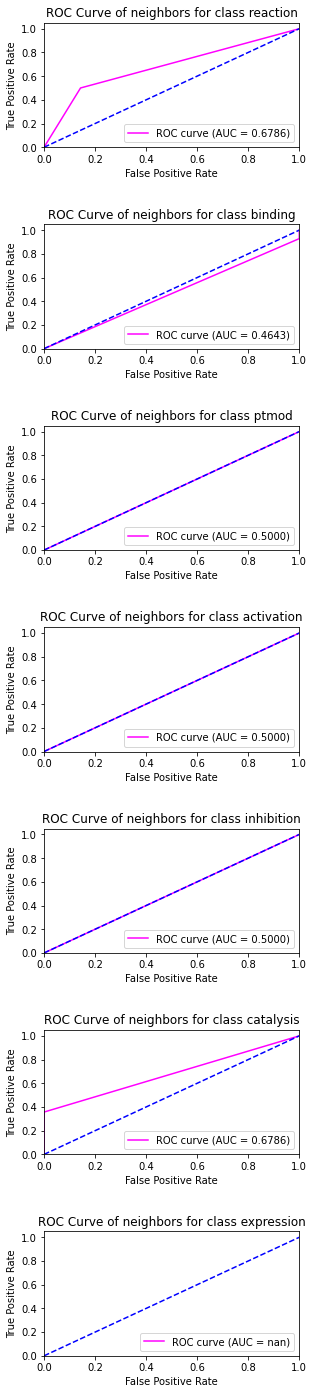

<Figure size 432x288 with 0 Axes>

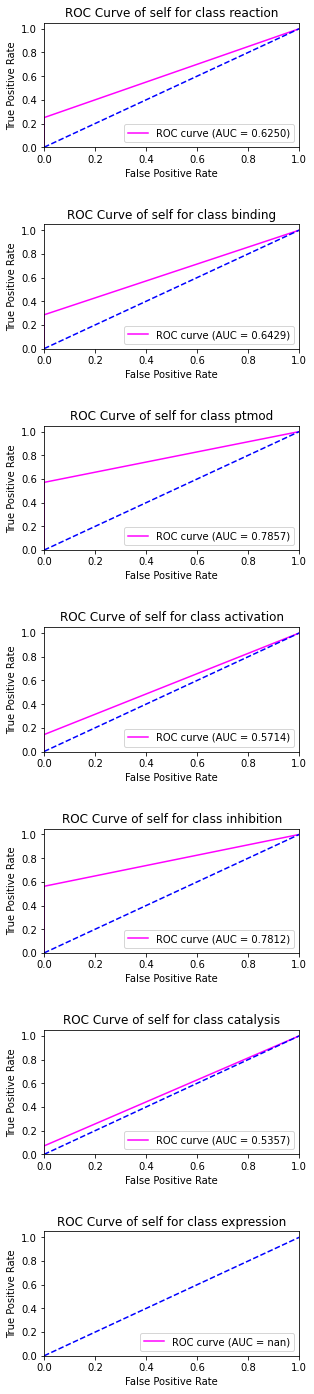

In [99]:
test_s(model_self, model_ngb, graph, graph.val_mask, device)

In [52]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [38]:
test_s(model_self, graph, graph.val_mask, device)

100%|██████████| 7/7 [00:01<00:00,  6.45it/s]

Recall: 0.35064935064889524, Precision: 0.9310344827554102, F1: 0.5094339622234425


In [39]:
model_ngb.load_state_dict(torch.load('/content/drive/My Drive/GNN_PPI/58ngb_train.ckpt'))
#model_ngb.eval()

<All keys matched successfully>

In [ ]:
test_s(model_ngb, graph, graph.val_mask, device)

## Comparison

In [ ]:
#@title
# comparison with benchmark model
#Learning Unknown from Correlations: Graph Neural Network for Inter-novel-protein Interaction Prediction
#GuofengLv, ZhiqiangHu, YanguangBi, ShaotingZhang

def train(model, graph, ppi_list, loss_fn, optimizer, device,
        result_file_path, summary_writer, save_path,
        batch_size=128, epochs=1000, scheduler=None, 
        got=False):

    global_step = 0
    global_best_valid_f1 = 0.0
    global_best_valid_f1_epoch = 0

    truth_edge_num = graph.edge_index.shape[1] // 2

    for epoch in range(epochs):

        recall_sum = 0.0
        precision_sum = 0.0
        f1_sum = 0.0
        loss_sum = 0.0

        steps = math.ceil(len(graph.train_mask) / batch_size)

        model.train()

        random.shuffle(graph.train_mask)
        random.shuffle(graph.train_mask_got)

        for step in range(steps):
            if step == steps-1:
                if got:
                    train_edge_id = graph.train_mask_got[step*batch_size:]
                else:
                    train_edge_id = graph.train_mask[step*batch_size:]
            else:
                if got:
                    train_edge_id = graph.train_mask_got[step*batch_size : step*batch_size + batch_size]
                else:
                    train_edge_id = graph.train_mask[step*batch_size : step*batch_size + batch_size]
            
            if got:
                output = model(graph.x, graph.edge_index_got, train_edge_id)
                label = graph.edge_attr_got[train_edge_id]
            else:
                output = model(graph.x, graph.edge_index, train_edge_id)
                label = graph.edge_attr_1[train_edge_id]
            
            label = label.type(torch.FloatTensor).to(device)

            loss = loss_fn(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            m = nn.Sigmoid()
            pre_result = (m(output) > 0.5).type(torch.FloatTensor).to(device)

            metrics = Metrictor_PPI(pre_result.cpu().data, label.cpu().data)

            metrics.show_result()

            recall_sum += metrics.Recall
            precision_sum += metrics.Precision
            f1_sum += metrics.F1
            loss_sum += loss.item()

            summary_writer.add_scalar('train/loss', loss.item(), global_step)
            summary_writer.add_scalar('train/precision', metrics.Precision, global_step)
            summary_writer.add_scalar('train/recall', metrics.Recall, global_step)
            summary_writer.add_scalar('train/F1', metrics.F1, global_step)

            global_step += 1
            print_file("epoch: {}, step: {}, Train: label_loss: {}, precision: {}, recall: {}, f1: {}"
                        .format(epoch, step, loss.item(), metrics.Precision, metrics.Recall, metrics.F1))
        
        torch.save({'epoch': epoch,
                    'state_dict': model.state_dict()},
                    os.path.join(save_path, 'gnn_model_train.ckpt'))
        
        valid_pre_result_list = []
        valid_label_list = []
        valid_loss_sum = 0.0

        model.eval()

        valid_steps = math.ceil(len(graph.val_mask) / batch_size)

        with torch.no_grad():
            for step in range(valid_steps):
                if step == valid_steps-1:
                    valid_edge_id = graph.val_mask[step*batch_size:]
                else:
                    valid_edge_id = graph.val_mask[step*batch_size : step*batch_size + batch_size]
                
                output = model(graph.x, graph.edge_index, valid_edge_id)
                label = graph.edge_attr_1[valid_edge_id]
                label = label.type(torch.FloatTensor).to(device)

                loss = loss_fn(output, label)
                valid_loss_sum += loss.item()

                m = nn.Sigmoid()
                pre_result = (m(output) > 0.5).type(torch.FloatTensor).to(device)

                valid_pre_result_list.append(pre_result.cpu().data)
                valid_label_list.append(label.cpu().data)
        
        valid_pre_result_list = torch.cat(valid_pre_result_list, dim=0)
        valid_label_list = torch.cat(valid_label_list, dim=0)

        metrics = Metrictor_PPI(valid_pre_result_list, valid_label_list)

        metrics.show_result()

        recall = recall_sum / steps
        precision = precision_sum / steps
        f1 = f1_sum / steps
        loss = loss_sum / steps

        valid_loss = valid_loss_sum / valid_steps

        if scheduler != None:
            scheduler.step(loss)
            print_file("epoch: {}, now learning rate: {}".format(epoch, scheduler.optimizer.param_groups[0]['lr']), save_file_path=result_file_path)
        
        if global_best_valid_f1 < metrics.F1:
            global_best_valid_f1 = metrics.F1
            global_best_valid_f1_epoch = epoch

            torch.save({'epoch': epoch, 
                        'state_dict': model.state_dict()},
                        os.path.join(save_path, 'gnn_model_valid_best.ckpt'))
        
        summary_writer.add_scalar('valid/precision', metrics.Precision, global_step)
        summary_writer.add_scalar('valid/recall', metrics.Recall, global_step)
        summary_writer.add_scalar('valid/F1', metrics.F1, global_step)
        summary_writer.add_scalar('valid/loss', valid_loss, global_step)

        print_file("epoch: {}, Training_avg: label_loss: {}, recall: {}, precision: {}, F1: {}, Validation_avg: loss: {}, recall: {}, precision: {}, F1: {}, Best valid_f1: {}, in {} epoch"
                    .format(epoch, loss, recall, precision, f1, valid_loss, metrics.Recall, metrics.Precision, metrics.F1, global_best_valid_f1, global_best_valid_f1_epoch), save_file_path=result_file_path)

In [ ]:
#@title Train and Evaluation

ppi_path = "/content/drive/My Drive/GNN_PPI/data/9606.protein.actions.all_connected.txt"
ppi_data = GNN_DATA(ppi_path)

pseq_path = "/content/drive/My Drive/GNN_PPI/data/protein.STRING_all_connected.sequences.dictionary.tsv"
vec_path = "/content/drive/My Drive/GNN_PPI/data/vec5_CTC.txt"

ppi_data.get_feature_origin(pseq_path=pseq_path, vec_path=vec_path)
ppi_data.generate_data()

split_new=True
split_mode = "bfs"
train_valid_index_path = "/content/drive/My Drive/GNN_PPI/string.bfs.fold1.json"
ppi_data.split_dataset(train_valid_index_path, random_new=split_new, mode=split_mode)

split_new=False

graph = ppi_data.data

ppi_list = ppi_data.ppi_list

graph.train_mask = ppi_data.ppi_split_dict['train_index']
graph.val_mask = ppi_data.ppi_split_dict['valid_index']


graph.edge_index_got = torch.cat((graph.edge_index[:, graph.train_mask], graph.edge_index[:, graph.train_mask][[1, 0]]), dim=1)
graph.edge_attr_got = torch.cat((graph.edge_attr_1[graph.train_mask], graph.edge_attr_1[graph.train_mask]), dim=0)
graph.train_mask_got = [i for i in range(len(graph.train_mask))]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
graph.to(device)

model = GIN_Net2(in_len=2000, in_feature=13, gin_in_feature=256, num_layers=1, pool_size=3, cnn_hidden=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

use_lr_scheduler = "True"
scheduler = None
if use_lr_scheduler:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

#loss func teacher
loss_fn = nn.BCEWithLogitsLoss().to(device)
graph_only_train = "False"

batch_size = 2048
epochs = 300
model.eval()



In [ ]:
# use the small data same as for our model
# ppi_path = "/content/drive/My Drive/GNN_PPI/data/9606.protein.actions.all_connected.txt"
# # ppi_data = GNN_DATA(ppi_path)

4775155it [00:14, 324603.35it/s]
100%|██████████| 593397/593397 [00:00<00:00, 835024.51it/s]


In [ ]:
# pseq_path = "/content/drive/My Drive/GNN_PPI/data/protein.STRING_all_connected.sequences.dictionary.tsv"
# vec_path = "/content/drive/My Drive/GNN_PPI/data/vec5_CTC.txt"

# ppi_data.get_feature_origin(pseq_path=pseq_path, vec_path=vec_path)

15335it [00:00, 241053.76it/s]


protein num: 15335
protein average length: 603.6829475057059
protein max & min length: 33423, 25
acid vector dimension: 13


100%|██████████| 15335/15335 [00:00<00:00, 1265711.31it/s]


In [ ]:
# ppi_data.generate_data()

In [ ]:
# split_new=True
# split_mode = "bfs"
# train_valid_index_path = "/content/drive/My Drive/GNN_PPI/string.bfs.fold1.json"
# ppi_data.split_dataset(train_valid_index_path, random_new=split_new, mode=split_mode)

use bfs methed split train and valid dataset


In [ ]:
# split_new=False

In [ ]:
# graph = ppi_data.data
# print(graph.x.shape)

torch.Size([15335, 2000, 13])


In [ ]:
# ppi_list = ppi_data.ppi_list

In [ ]:
# graph.train_mask = ppi_data.ppi_split_dict['train_index']
# graph.val_mask = ppi_data.ppi_split_dict['valid_index']

In [ ]:
# print("train gnn, train_num: {}, valid_num: {}".format(len(graph.train_mask), len(graph.val_mask)))

train gnn, train_num: 474637, valid_num: 118760


In [ ]:
# graph.edge_index_got = torch.cat((graph.edge_index[:, graph.train_mask], graph.edge_index[:, graph.train_mask][[1, 0]]), dim=1)
# graph.edge_attr_got = torch.cat((graph.edge_attr_1[graph.train_mask], graph.edge_attr_1[graph.train_mask]), dim=0)
# graph.train_mask_got = [i for i in range(len(graph.train_mask))]

In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

cuda:0


In [ ]:
# graph.to(device)

Data(x=[15335, 2000, 13], edge_index=[2, 1186794], edge_attr_1=[1186794, 7], train_mask=[474637], val_mask=[118760], edge_index_got=[2, 949274], edge_attr_got=[949274, 7], train_mask_got=[474637])

In [ ]:
# model = GIN_Net2(in_len=2000, in_feature=13, gin_in_feature=256, num_layers=1, pool_size=3, cnn_hidden=1).to(device)

In [ ]:
# #@title 
# #optimizer 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
# #@title
# use_lr_scheduler = "True"
# scheduler = None
# if use_lr_scheduler:
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

In [ ]:
# #@title 
# #loss function teacher
# loss_fn = nn.BCEWithLogitsLoss().to(device)

In [30]:
# #@title
# graph_only_train = "False"

# batch_size = 2048
# epochs = 300


In [ ]:
# #@title
# #teacher model summary
# model.load_state_dict(torch.load("/content/drive/My Drive/GNN_PPI/save_model_/gnn_string_bfs/gnn_model_train.ckpt")['state_dict'])
# model.eval()

GIN_Net2(
  (conv1d): Conv1d(13, 1, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (biGRU): GRU(1, 1, batch_first=True, bidirectional=True)
  (maxpool1d): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (global_avgpool1d): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=666, out_features=256, bias=True)
  (gin_conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  ))
  (gin_convs): ModuleList()
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

In [ ]:
# test_all = "False"
# description = "test"

In [ ]:
# # ppi_data = GNN_DATA(ppi_path=ppi_path)
# # ppi_data.get_feature_origin(pseq_path=pseq_path, vec_path=vec_path)
# # ppi_data.generate_data()

# # graph = ppi_data.data
# temp =graph.edge_index.transpose(0, 1).cpu().numpy()
# ppi_list = []

# for edge in temp:
#     ppi_list.append(list(edge))

# truth_edge_num = len(ppi_list) // 2
# # fake_edge_num = len(ppi_data.fake_edge) // 2
# fake_edge_num = 0

In [ ]:
# index_path = "/content/drive/My Drive/GNN_PPI/string.bfs.fold1.json"
# gnn_model = "/content/drive/My Drive/GNN_PPI/save_model_/gnn_string_bfs/gnn_model_train.ckpt"

In [ ]:
# with open(index_path, 'r') as f:
#     index_dict = json.load(f)
#     f.close()
# graph.train_mask = index_dict['train_index']
# graph.val_mask = index_dict['valid_index']

# print("train gnn, train_num: {}, valid_num: {}".format(len(graph.train_mask), len(graph.val_mask)))


In [ ]:
# node_vision_dict = {}
# for index in graph.train_mask:
#     ppi = ppi_list[index]
#     if ppi[0] not in node_vision_dict.keys():
#         node_vision_dict[ppi[0]] = 1
#     if ppi[1] not in node_vision_dict.keys():
#         node_vision_dict[ppi[1]] = 1

# for index in graph.val_mask:
#     ppi = ppi_list[index]
#     if ppi[0] not in node_vision_dict.keys():
#         node_vision_dict[ppi[0]] = 0
#     if ppi[1] not in node_vision_dict.keys():
#         node_vision_dict[ppi[1]] = 0

# vision_num = 0
# unvision_num = 0
# for node in node_vision_dict:
#     if node_vision_dict[node] == 1:
#         vision_num += 1
#     elif node_vision_dict[node] == 0:
#         unvision_num += 1
# print("vision node num: {}, unvision node num: {}".format(vision_num, unvision_num))

# test1_mask = []
# test2_mask = []
# test3_mask = []

# for index in graph.val_mask:
#     ppi = ppi_list[index]
#     temp = node_vision_dict[ppi[0]] + node_vision_dict[ppi[1]]
#     if temp == 2:
#         test1_mask.append(index)
#     elif temp == 1:
#         test2_mask.append(index)
#     elif temp == 0:
#         test3_mask.append(index)
# print("test1 edge num: {}, test2 edge num: {}, test3 edge num: {}".format(len(test1_mask), len(test2_mask), len(test3_mask)))

# graph.test1_mask = test1_mask
# graph.test2_mask = test2_mask
# graph.test3_mask = test3_mask


In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #changed 1 to 0 

In [81]:
#@title
# model architecture to load
class GIN_Net2(torch.nn.Module):
    def __init__(self, in_len=2000, in_feature=13, gin_in_feature=256, num_layers=1, 
                hidden=512, use_jk=False, pool_size=3, cnn_hidden=1, train_eps=True, 
                feature_fusion=None, class_num=7):
        super(GIN_Net2, self).__init__()
        self.use_jk = use_jk
        self.train_eps = train_eps
        self.feature_fusion = feature_fusion

        self.conv1d = nn.Conv1d(in_channels=in_feature, out_channels=cnn_hidden, kernel_size=3, padding=0)
        self.bn1 = nn.BatchNorm1d(cnn_hidden)
        self.biGRU = nn.GRU(cnn_hidden, cnn_hidden, bidirectional=True, batch_first=True, num_layers=1)
        self.maxpool1d = nn.MaxPool1d(pool_size, stride=pool_size)
        self.global_avgpool1d = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(math.floor(in_len / pool_size), gin_in_feature)

        self.gin_conv1 = GINConv( 
            nn.Sequential(
                nn.Linear(gin_in_feature, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.BatchNorm1d(hidden),
            ), train_eps=self.train_eps
        )
        self.gin_convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.gin_convs.append(
                GINConv(
                    nn.Sequential(
                        nn.Linear(hidden, hidden),
                        nn.ReLU(),
                        nn.Linear(hidden, hidden),
                        nn.ReLU(),
                        nn.BatchNorm1d(hidden),
                    ), train_eps=self.train_eps
                )
            )
        if self.use_jk:
            mode = 'cat'
            self.jump = JumpingKnowledge(mode)
            self.lin1 = nn.Linear(num_layers*hidden, hidden)
        else:
            self.lin1 = nn.Linear(hidden, hidden)
        self.lin2 = nn.Linear(hidden, hidden)
        self.fc2 = nn.Linear(hidden, class_num)
    
    def reset_parameters(self):
        
        self.conv1d.reset_parameters()
        self.fc1.reset_parameters()

        self.gin_conv1.reset_parameters()
        for gin_conv in self.gin_convs:
            gin_conv.reset_parameters()
        
        if self.use_jk:
            self.jump.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

        self.fc2.reset_parameters()
    
    def forward(self, x, edge_index, train_edge_id, p=0.5):
        x = x.transpose(1, 2)
        x = self.conv1d(x)
        x = self.bn1(x)
        x = self.maxpool1d(x)
        x = x.transpose(1, 2)
        x, _ = self.biGRU(x)
        x = self.global_avgpool1d(x)
        x = x.squeeze()
        x = self.fc1(x)

        x = self.gin_conv1(x, edge_index)
        xs = [x]
        for conv in self.gin_convs:
            x = conv(x, edge_index)
            xs += [x]

        if self.use_jk:
            x = self.jump(xs)
        
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=p, training=self.training)
        x = self.lin2(x)
        # x  = torch.add(x, x_)

        node_id = edge_index[:, train_edge_id]
        x1 = x[node_id[0]]
        x2 = x[node_id[1]]

        if self.feature_fusion == 'concat':
            x = torch.cat([x1, x2], dim=1)
        else:
            x = torch.mul(x1, x2)
        x = self.fc2(x)

        return x

In [82]:
model = GIN_Net2(in_len=2000, in_feature=13, gin_in_feature=256, num_layers=1, pool_size=3, cnn_hidden=1).to(device)

In [83]:
model.eval()

GIN_Net2(
  (conv1d): Conv1d(13, 1, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (biGRU): GRU(1, 1, batch_first=True, bidirectional=True)
  (maxpool1d): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (global_avgpool1d): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=666, out_features=256, bias=True)
  (gin_conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  ))
  (gin_convs): ModuleList()
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

In [94]:
#@title test
def test(model, graph, test_mask, device):
    valid_pre_result_list = []
    valid_label_list = []

    model.eval()

    batch_size = 256

    valid_steps = math.ceil(len(test_mask) / batch_size)

    for step in tqdm(range(valid_steps)):
        if step == valid_steps-1:
            valid_edge_id = test_mask[step*batch_size:]
        else:
            valid_edge_id = test_mask[step*batch_size : step*batch_size + batch_size]

        output = model(graph.x, graph.edge_index, valid_edge_id)
        label = graph.edge_attr_1[valid_edge_id]
        label = label.type(torch.FloatTensor).to(device)

        m = nn.Sigmoid()
        pre_result = (m(output) > 0.5).type(torch.FloatTensor).to(device)

        valid_pre_result_list.append(pre_result.cpu().data)
        valid_label_list.append(label.cpu().data)

    valid_pre_result_list = torch.cat(valid_pre_result_list, dim=0)
    valid_label_list = torch.cat(valid_label_list, dim=0)

    metrics = Metrictor_PPI(valid_pre_result_list, valid_label_list)

    metrics.show_result()


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    l=['reaction', 'binding', 'ptmod', 'activation', 'inhibition', 'catalysis', 'expression']


    for j,i in zip(l,range(7)):
      fpr[i], tpr[i], _= roc_curve(valid_label_list[:, i], valid_pre_result_list[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      print("The AUC of subclass ", j," is "+str(roc_auc[i]))
    plt.figure()
    fig, axs = plt.subplots(7, 1, figsize=(5, 20)) 
    for i, ax in zip(range(7), axs.ravel()):
      ax.plot(fpr[i],tpr[i],color='magenta',label= 'ROC curve (AUC = %0.4f)' % roc_auc[i]) 
      ax.plot([0, 1], [0, 1], 'b--')
      ax.set_xlim([0.0, 1.0])
      ax.set_ylim([0.0, 1.05])
      ax.set_xlabel("False Positive Rate")
      ax.set_ylabel("True Positive Rate")
      ax.set_title('ROC Curve of benchmark for class '+ l[i]) 
      ax.legend(loc= "lower right")
      fig.tight_layout(pad=3.0)
    x=random.randint(1,100)
    plt.savefig('./ROC_Curve_'+str(x)+'_.png')

    print("Recall: {}, Precision: {}, F1: {}".format(metrics.Recall, metrics.Precision, metrics.F1))

100%|██████████| 7/7 [00:00<00:00, 38.47it/s]


The AUC of subclass  reaction  is 0.5
The AUC of subclass  binding  is 0.5
The AUC of subclass  ptmod  is 0.4584717927047118
The AUC of subclass  activation  is 0.5
The AUC of subclass  inhibition  is 0.5098676735080805
The AUC of subclass  catalysis  is 0.5656224288942813
The AUC of subclass  expression  is 0.5
Recall: 0.551876379690929, Precision: 0.27208416470160945, F1: 0.36447576231755946


<Figure size 432x288 with 0 Axes>

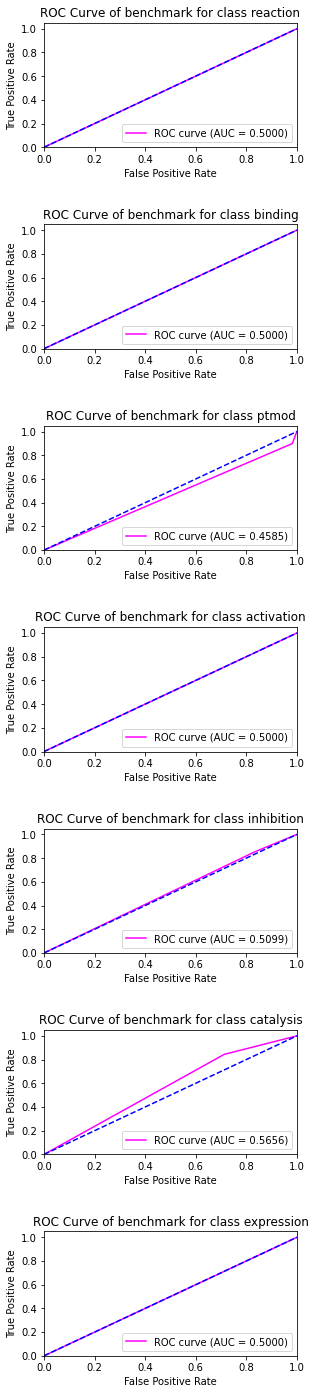

In [95]:
test(model, graph, graph.val_mask, device)

In [89]:
test(model, graph, graph.val_mask, device)

100%|██████████| 7/7 [00:00<00:00, 42.28it/s]


Recall: 0.551876379690929, Precision: 0.27208416470160945, F1: 0.36447576231755946
